**주요 내용**

- v1, v2 모델중에서 좋은 결과를 낸 모델들을 대상으로 SHAP 분석 진행

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

**한국 교사들 데이터**

In [2]:
teacher_df = pd.read_csv('data/CY08MSP_TCH_KOR_VARS select.csv')

In [3]:
teacher_df = teacher_df.iloc[:, :-1]  # 마지막 열 제거
teacher_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3614 entries, 0 to 3613
Columns: 526 entries, CNT to VER_DAT
dtypes: float64(117), int64(407), object(2)
memory usage: 14.5+ MB


**한국 교수들 데이터에 사용된 변수 목록**

In [4]:
teacher_vars_origin = pd.read_csv('data/TCH_VARS_original.csv')
teacher_vars_origin.head()

,변수,설명,측도,결측값
0,CNT,Country code 3-character,명목(N),없음
1,CNTTCHID,Intl. Teacher ID,명목(N),없음
2,TCHTYPE,Teacher Type,명목(N),"7, 8, 9"
3,TC001Q01NA,Are you female or male?,명목(N),95 - 99
4,TC002Q01NA,How old are you?,척도(S),95 - 99


**분석 대상 변수 목록 지정**

In [5]:
teacher_vars = pd.read_csv('data/TCH_VARS_selected.csv')
teacher_vars_list = teacher_vars['변수'].to_list()

In [6]:
teacher_df = teacher_df[teacher_vars_list]
teacher_df.shape

(3614, 118)

**결측치 확인 후 전처리**

- 99 등이 결측치 대신 사용됨.

In [7]:
teacher_df.describe(percentiles=[0.9, 0.92, 0.95, 0.99])

,TCHTYPE,TC001Q01NA,TC002Q01NA,TC007Q02NA,TC215Q01JA,TC216Q01JA,TC216Q02JA,TC216Q03JA,TC216Q04JA,TC216Q05JA,...,CREATPED,CAPCON,AFFECT,TRUST,OVERLOAD,AUTONOMY,LEADSHIP,OCSTRESS,STRESS,NEGSYMPT
count,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,...,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000,3614.000000
mean,1.684283,1.573879,43.959878,16.259546,350.731599,28.769231,27.575816,48.882125,58.855285,52.203929,...,0.825549,0.967207,0.781324,0.846966,1.453154,1.155628,1.357440,1.490599,1.458462,1.674074
std,0.464865,3.660585,9.821958,11.012970,5508.108954,110.347336,135.708507,207.872831,228.213614,213.661046,...,11.185266,11.292714,10.945370,10.934424,11.343863,10.534830,12.175294,11.094712,11.934829,12.136062
min,1.000000,1.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.804800,-3.894700,-3.139800,-3.009000,-3.506700,-3.401700,-2.030100,-3.761100,-2.721200,-2.325700
50%,2.000000,1.000000,44.000000,16.000000,40.000000,16.000000,8.000000,3.000000,3.000000,3.000000,...,-0.619800,-0.137700,-0.054400,-0.475100,0.167600,-0.161800,-0.294600,0.209400,0.167100,0.251400
90%,2.000000,2.000000,57.000000,31.000000,60.000000,20.000000,18.000000,10.000000,10.000000,10.000000,...,0.917300,1.064800,0.853210,1.191300,1.049510,1.344200,0.858900,0.988000,0.963380,1.193170
92%,2.000000,2.000000,58.000000,32.000000,60.000000,20.000000,20.000000,10.000000,10.000000,13.000000,...,1.056900,1.210300,1.165900,1.557900,1.155900,1.726400,1.130800,1.142872,1.071476,1.319288
95%,2.000000,2.000000,60.000000,34.000000,65.000000,23.000000,23.000000,20.000000,999.000000,54.150000,...,1.766800,2.312300,1.740600,1.557900,1.474300,2.565200,1.821400,1.385700,1.277210,1.670440
99%,2.000000,2.000000,62.000000,37.870000,193.500000,999.000000,999.000000,999.000000,999.000000,999.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000
max,2.000000,99.000000,99.000000,99.000000,99999.000000,999.000000,999.000000,999.000000,999.000000,999.000000,...,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000,99.000000


In [8]:
teacher_vars_df = teacher_vars.merge(teacher_vars_origin, on='변수', how='left')
teacher_vars_df

,변수,설명,측도,결측값
0,TCHTYPE,Teacher Type,명목(N),"7, 8, 9"
1,TC001Q01NA,Are you female or male?,명목(N),95 - 99
2,TC002Q01NA,How old are you?,척도(S),95 - 99
3,TC007Q02NA,How many years of work experience do you have:...,척도(S),95 - 99
4,TC215Q01JA,"During most recent complete calendar week, app...",명목(N),99995 - 99999
...,...,...,...,...
113,AUTONOMY,Teachers' work autonomy (WLE),척도(S),95.0000 - 99.0000
114,LEADSHIP,School leadership (WLE),척도(S),95.0000 - 99.0000
115,OCSTRESS,Occupational stress (WLE),척도(S),95.0000 - 99.0000
116,STRESS,Sources of stress (WLE),척도(S),95.0000 - 99.0000


**변수별 결측치값 확인**

변수별 결측치값을 실제 결측치로 간주되도록 모두 `np.nan`으로 대체한다.
`missing_map는` 열별 결측치를 어레이로 지정한다.

In [9]:
import re
delimiter = r' - |, ' # 결측값 표현에 사용된 구분자: ' - ' 또는 ', '

def parse_missing_codes(code_str):
    """'99, 999' -> [99.0, 999.0] 변환"""
    if pd.isna(code_str) or code_str == '':
        return np.array([np.nan])
    elif code_str == '없음':
        return np.array([np.nan])
    else:
        missing_range = [float(x.strip()) for x in re.split(delimiter, str(code_str))]
        return np.arange(missing_range[0], missing_range[-1] + 1)

# 변수명-결측값 어레이 사전 생성
missing_map = dict(zip(
    teacher_vars_df['변수'],
    teacher_vars_df['결측값'].apply(parse_missing_codes)
))

In [10]:
missing_map

{'TCHTYPE': array([7., 8., 9.]),
 'TC001Q01NA': array([95., 96., 97., 98., 99.]),
 'TC002Q01NA': array([95., 96., 97., 98., 99.]),
 'TC007Q02NA': array([95., 96., 97., 98., 99.]),
 'TC215Q01JA': array([99995., 99996., 99997., 99998., 99999.]),
 'TC216Q01JA': array([995., 996., 997., 998., 999.]),
 'TC216Q02JA': array([995., 996., 997., 998., 999.]),
 'TC216Q03JA': array([995., 996., 997., 998., 999.]),
 'TC216Q04JA': array([995., 996., 997., 998., 999.]),
 'TC216Q05JA': array([995., 996., 997., 998., 999.]),
 'TC216Q06JA': array([995., 996., 997., 998., 999.]),
 'TC216Q07JA': array([995., 996., 997., 998., 999.]),
 'TC217Q01NA': array([95., 96., 97., 98., 99.]),
 'TC216Q08JA': array([995., 996., 997., 998., 999.]),
 'TC218Q01JA': array([95., 96., 97., 98., 99.]),
 'TC150Q01HA': array([95., 96., 97., 98., 99.]),
 'TC150Q02HA': array([95., 96., 97., 98., 99.]),
 'TC150Q03HA': array([95., 96., 97., 98., 99.]),
 'TC150Q04HA': array([95., 96., 97., 98., 99.]),
 'TC150Q06HA': array([95., 96.

열별 결측값을 일괄적으로 `np.nan`으로 치환

In [11]:
for col, codes in missing_map.items():
    if len(codes) > 1:
        teacher_df.loc[teacher_df.loc[:, col].isin(codes), col] = np.nan

In [12]:
teacher_df.describe()

,TCHTYPE,TC001Q01NA,TC002Q01NA,TC007Q02NA,TC215Q01JA,TC216Q01JA,TC216Q02JA,TC216Q03JA,TC216Q04JA,TC216Q05JA,...,CREATPED,CAPCON,AFFECT,TRUST,OVERLOAD,AUTONOMY,LEADSHIP,OCSTRESS,STRESS,NEGSYMPT
count,3614.000000,3609.000000,3608.000000,3604.000000,3603.000000,3568.000000,3545.000000,3449.000000,3413.000000,3439.000000,...,3568.000000,3567.000000,3570.000000,3570.000000,3566.000000,3573.000000,3559.000000,3568.000000,3561.000000,3559.000000
mean,1.684283,1.438903,43.868348,16.030244,46.504302,16.260650,8.667983,3.428530,3.487841,4.024426,...,-0.440153,-0.324506,-0.429214,-0.362764,0.140129,0.032868,-0.151507,0.233471,0.006706,0.170020
std,0.464865,0.496322,9.569938,10.129877,123.273670,6.119032,6.711867,3.674812,3.799902,4.835814,...,0.909236,0.933495,0.938867,0.894372,0.757571,1.053157,0.934281,0.695030,0.897948,0.934558
min,1.000000,1.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,-3.804800,-3.894700,-3.139800,-3.009000,-3.506700,-3.401700,-2.030100,-3.761100,-2.721200,-2.325700
25%,1.000000,1.000000,36.000000,8.000000,25.000000,15.000000,5.000000,1.000000,2.000000,1.000000,...,-1.003425,-0.924100,-1.005800,-0.887800,-0.351600,-0.627800,-0.634800,-0.014900,-0.332400,-0.230350
50%,2.000000,1.000000,44.000000,15.500000,40.000000,16.000000,8.000000,2.000000,3.000000,3.000000,...,-0.636300,-0.137700,-0.054400,-0.475100,0.135000,-0.184300,-0.303400,0.209400,0.147300,0.243200
75%,2.000000,2.000000,51.000000,23.000000,50.000000,18.000000,10.000000,5.000000,5.000000,5.000000,...,0.018900,-0.137700,-0.054400,0.200700,0.581200,0.613100,0.400300,0.591500,0.503200,0.703000
max,2.000000,2.000000,64.000000,46.000000,3310.000000,100.000000,80.000000,70.000000,60.000000,100.000000,...,1.766800,2.330100,1.740600,1.557900,3.371300,2.565200,2.754700,1.465000,3.682900,3.838000


열별 결측치 개수를 확인한다.
종속 변수로 사용될 FEEDBINSTR와 FEEDBINSTR에 각각 583개의 결측치가 존재한다.

In [13]:
teacher_df[['FEEDBINSTR', 'ADAPTINSTR']].isnull().sum()

FEEDBINSTR    583
ADAPTINSTR    583
dtype: int64

아래 19개 변수(열)에서의 결측치가 86%를 넘기에 모두 삭제한다.

In [14]:
teacher_df.isnull().sum().sort_values(ascending=False).head(20)

TC150Q06HA    3134
TC150Q04HA    3127
TC150Q03HA    3122
TC150Q02HA    3121
TC204Q03HA    3119
TC150Q08HA    3118
TC204Q02HA    3118
TC204Q01HA    3118
TC203Q03HA    3117
TC203Q02HA    3117
TC203Q01HA    3117
EXPO21TC      3115
TCDISCLIMA    3114
ICTMATTC      3114
COGACMTC      3114
COGACRTC      3114
TCMGOALS      3114
TC150Q01HA    3113
TC231Q01JA    3113
ICTOTL         593
dtype: int64

In [15]:
3113/teacher_df.shape[0]

0.8613724405091312

In [16]:
columns_to_drop = teacher_df.isnull().sum().sort_values(ascending=False).head(19).index.tolist()
teacher_df = teacher_df.drop(columns=columns_to_drop)

In [17]:
teacher_df.shape

(3614, 99)

**종속변수의 결측치 제거**

종속변수로 사용될 FEEDBINSTR와 ADAPTINSTR 값이 결측치인 행은 모두 삭제한다.

In [18]:
teacher_df = teacher_df.dropna(subset=['FEEDBINSTR', 'ADAPTINSTR'], how='any')

남은 결측치

In [19]:
teacher_df.isnull().sum().sort_values(ascending=False).head(30)

TC216Q08JA    332
TC216Q07JA    315
TC245Q01JA    220
TC244Q05JA    177
TC244Q04JA    176
TC244Q03JA    175
TC244Q02JA    172
TC244Q06JA    169
TC216Q04JA    165
TC244Q01JA    159
TC216Q03JA    135
TC216Q05JA    131
PROPWORK      110
TC216Q06JA     65
TC216Q02JA     49
TC216Q01JA     34
TCICTUSE       32
DEVNEED        27
ICTCOMP        23
NEGSYMPT       20
LEADSHIP       17
TCDIGRES       17
STRESS         15
ICTOTL         15
TC247Q04JA     14
TC247Q02JA     14
TC247Q01JA     13
TC247Q03JA     10
CAPCON         10
EXCHT          10
dtype: int64

아래 5 개의 열은 분석에 사용하지 않음.

In [20]:
columns_to_drop2 = ['TC216Q07JA', 'TC216Q08JA'] + ['TC244Q05JA'] + ['PROPWORK', 'COBN_T']
teacher_df = teacher_df.drop(columns=columns_to_drop2, axis=1)

나머지 결측치는 모두 삭제

In [21]:
teacher_df = teacher_df.dropna()

총 95개의 열을 갖는 2,406 데이터셋이 생성됨.

In [22]:
teacher_df.shape

(2406, 94)

### 열별 측도 조정

열별로 지정된 측도는 세 종류다.

In [23]:
teacher_vars_df['측도'].value_counts()

측도
순서(O)    44
명목(N)    39
척도(S)    35
Name: count, dtype: int64

In [24]:
mask_order = teacher_vars_df['측도'] == '순서(O)'
order_cols = teacher_vars_df.loc[mask_order, '변수'].to_list()
order_cols = [col for col in order_cols if col in teacher_df.columns]
len(order_cols)

42

In [25]:
mask_nominal = teacher_vars_df['측도'] == '명목(N)'
nominal_cols = teacher_vars_df.loc[mask_nominal, '변수'].to_list()
nominal_cols = [col for col in nominal_cols if col in teacher_df.columns]
len(nominal_cols)

22

In [26]:
mask_scala = teacher_vars_df['측도'] == '척도(S)'
scala_cols = teacher_vars_df.loc[mask_scala, '변수'].to_list()
scala_cols = [col for col in scala_cols if col in teacher_df.columns]
len(scala_cols)

30

명목 열의 dtype을 object로 변환시킨다.

In [27]:
for col in nominal_cols:
    teacher_df[col] = teacher_df[col].astype('object')  # pandas ObjectDtype

In [28]:
nominal_cols = teacher_df.select_dtypes(include=['object']).columns.tolist()
nominal_cols

['TCHTYPE',
 'TC001Q01NA',
 'TC215Q01JA',
 'TC216Q01JA',
 'TC216Q02JA',
 'TC216Q03JA',
 'TC216Q04JA',
 'TC216Q05JA',
 'TC216Q06JA',
 'TC217Q01NA',
 'TC218Q01JA',
 'TC244Q01JA',
 'TC244Q02JA',
 'TC244Q03JA',
 'TC244Q04JA',
 'TC244Q06JA',
 'TC245Q01JA',
 'TC247Q01JA',
 'TC247Q02JA',
 'TC247Q03JA',
 'TC247Q04JA',
 'TC248Q01JA']

### 명목열 원-핫 인코딩 전처리

In [29]:
teacher_df = pd.get_dummies(teacher_df,
                            columns=nominal_cols,
                            prefix=nominal_cols,
                            prefix_sep="_",
                            dummy_na=False,
                            dtype=np.float64,
                            )

print(f"원-핫 인코딩 완료: {len(nominal_cols)}개 열 -> {teacher_df.shape[1]}개 총 열")

원-핫 인코딩 완료: 22개 열 -> 676개 총 열


In [30]:
teacher_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2406 entries, 3 to 3613
Columns: 676 entries, TC002Q01NA to TC248Q01JA_2.0
dtypes: float64(676)
memory usage: 12.4 MB


#### 훈련셋 지정

- 'FEEDBINSTR', 'ADAPTINSTR'를 메인 타깃으로 사용하기에 컬럼에서 제외한다.

In [31]:
main_targets = ['FEEDBINSTR', 'ADAPTINSTR']
train_df = teacher_df.drop(columns=main_targets, axis=1)

## Optuna를 활용한 하이퍼파라미터 튜닝

- PyCaret의 `compare_models`를 활용한 결과 GradientBoosting 모델의 성능이 가장 좋았음.
- 따라서 Optuna를 활용하여 GradientBoosting 모델의 하이퍼파라미터 튜닝을 수행함.

In [32]:
import optuna
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, r2_score

def objective(trial, model, X, y, cv=5, scoring='r2'):
    # 하이퍼파라미터 탐색 공간 정의
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'random_state': 42
    }
    
    # 모델 생성
    model = model(**params)
    
    # n-fold 교차 검증 수행
    scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)

    # 평균 R2 점수 반환
    return scores.mean()

**특성 중요도 확인**

- 특성 중요도가 높은 변수부터

In [33]:
def get_feature_importances(model, data_df, target, verbose = False, num_features=20):
    importances = model.feature_importances_
    
    indices = np.argsort(importances)[::-1]

    if target in data_df.columns:
        input_df = data_df.drop(columns=[target])
    else:
        input_df = data_df
    
    important_features = [(input_df.columns[i], importances[i]) for i in indices]

    # 특성중요도 출력
    if verbose:
        print(f"\nTop {num_features} Feature Importances:")
        for name, score in important_features[:num_features]:
            print(f"{name:40s} {score:.4f}")
    
    return important_features

**특성 중요도 그래프 그리기**

In [34]:
def plot_feature_importances(important_features, target, num_features=20):
    plt.style.use("seaborn-v0_8-white")  # 그리드 없는 심플 스타일
    plt.rcParams["font.family"] = "DejaVu Sans"

    if num_features is None:
        num_features = len(important_features)
    important_features = important_features[:num_features]

    feat_names = [name for name, _ in important_features]
    feat_scores = [score for _, score in important_features]

    indices = range(len(feat_scores))

    feat_names_plot = [feat_names[i] for i in indices][::-1]
    feat_scores_plot = [feat_scores[i] for i in indices][::-1]

    plt.figure(figsize=(9, 7))

    colors = plt.cm.Blues(
        [0.3 + 0.7 * (i / max(1, len(feat_scores_plot) - 1))
        for i in range(len(feat_scores_plot))]
    )

    bars = plt.barh(
        range(len(feat_scores_plot)),
        feat_scores_plot,
        color=colors,
        edgecolor="none"
    )

    max_score = max(feat_scores_plot)
    plt.xlim(0, max_score * 1.1)  # 10% 여유. 더 넓게 하려면 계수 조절

    plt.yticks(range(len(feat_scores_plot)), feat_names_plot, fontsize=9)
    plt.xlabel("Feature Importance", fontsize=11)
    plt.title(f"Target: {target}", fontsize=13, pad=10)

    # 특성중요도 값 레이블 추가
    for bar, score in zip(bars, feat_scores_plot):
        width = bar.get_width()
        plt.text(
            width + max(feat_scores_plot) * 0.01,
            bar.get_y() + bar.get_height() / 2,
            f"{score:.3f}",
            va="center",
            fontsize=8
        )

    plt.tight_layout()
    plt.show()

### 종속변수: FEEDBINSTR

In [35]:
target = 'FEEDBINSTR'
X = train_df
y = teacher_df[target]

model = GradientBoostingRegressor

#### 저장된 모델 불러오기

In [36]:
import joblib
import json
from datetime import datetime
import os

In [37]:
# 파일명 규칙: target_모델_YYYYmmdd_HHMM_version.pkl
target = 'FEEDBINSTR'
model_fname = f"models/gb_{target}_v3.pkl"
final_model = joblib.load(model_fname)

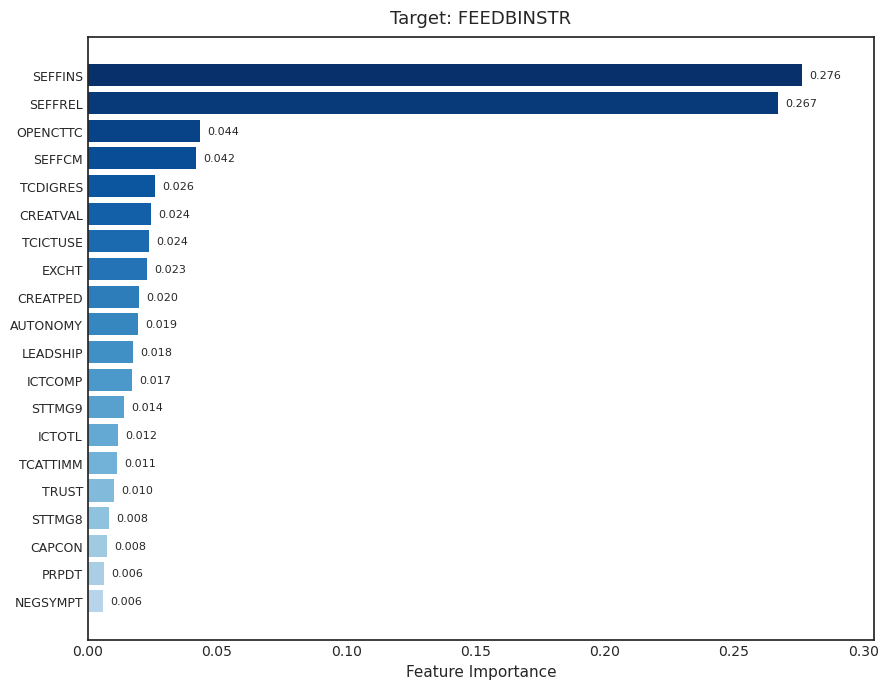

In [38]:
# 특성 중요도 확인 (Optuna 튜닝 모델)
important_features = get_feature_importances(final_model, X, target)

# 특성 중요도 시각화 (Optuna 튜닝 모델)
plot_feature_importances(important_features, target)

#### 가장 중요한 변수 50개만 대상으로 특성 중요도 파악

In [39]:
feature_importances = get_feature_importances(final_model, X, target)

In [40]:
top50_features = [feature for feature, _ in feature_importances[:50]]
top50_features


['SEFFINS',
 'SEFFREL',
 'OPENCTTC',
 'SEFFCM',
 'TCDIGRES',
 'CREATVAL',
 'TCICTUSE',
 'EXCHT',
 'CREATPED',
 'AUTONOMY',
 'LEADSHIP',
 'ICTCOMP',
 'STTMG9',
 'ICTOTL',
 'TCATTIMM',
 'TRUST',
 'STTMG8',
 'CAPCON',
 'PRPDT',
 'NEGSYMPT',
 'STTMG4',
 'DEVNEED',
 'TC007Q02NA',
 'TCWKLOAD',
 'TC216Q05JA_1.0',
 'SATJOB',
 'OVERLOAD',
 'SATTEACH',
 'TC002Q01NA',
 'AFFECT',
 'STTMG5',
 'TC244Q03JA_5.0',
 'TC245Q01JA_24.0',
 'STTMG3',
 'NTEACH5',
 'STRESS',
 'NTEACH9',
 'TCISCED',
 'OCSTRESS',
 'TC216Q05JA_10.0',
 'STTMG6',
 'TC245Q01JA_35.0',
 'TC247Q02JA_1.0',
 'TC247Q01JA_2.0',
 'STTMG2',
 'TC258Q01JA',
 'TC216Q01JA_22.0',
 'NTEACH8',
 'TC247Q04JA_5.0',
 'TC245Q01JA_30.0']

In [41]:
target = 'FEEDBINSTR'
X_top50 = train_df[top50_features]
y = teacher_df[target]

model_top50 = GradientBoostingRegressor

#### 저장된 모델 불러오기

In [42]:
model_fname_top50 = f"models/gb_{target}_v3_top50.pkl"
final_model_top50 = joblib.load(model_fname_top50)

In [43]:
# 예시: 모델 객체에서 직접 확인
X_top50 = train_df[final_model_top50.feature_names_in_]

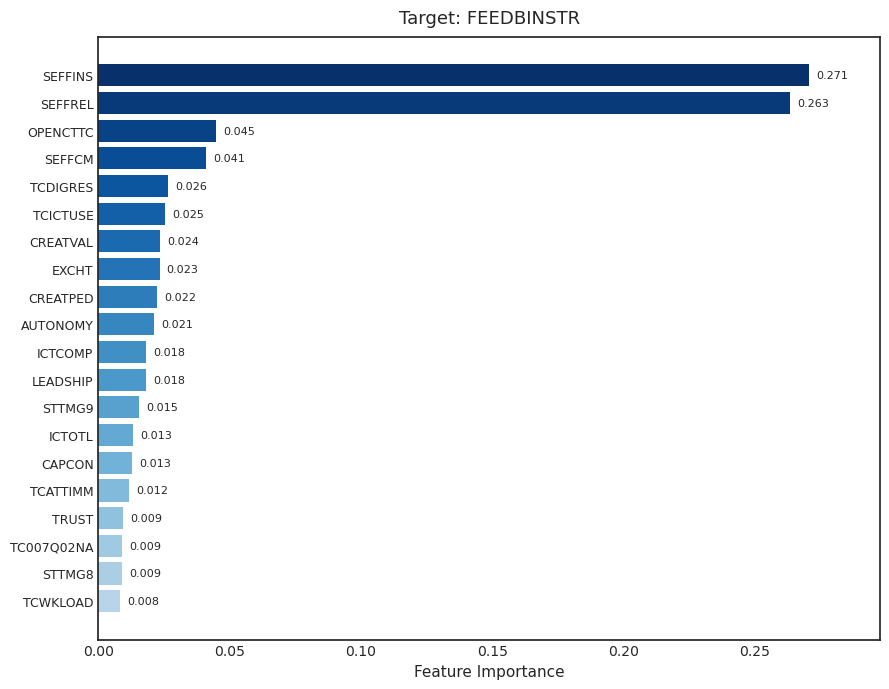

In [44]:
# 특성 중요도 확인 (Optuna 튜닝 모델)
important_features_top = get_feature_importances(final_model_top50, X_top50, target)

# 특성 중요도 시각화 (Optuna 튜닝 모델)
plot_feature_importances(important_features_top, target)

### SHAP Analysis: Beeswarm Plot
`final_model_top50` 모델에 대해 SHAP 값을 계산하고, Beeswarm 플롯을 통해 각 특성이 예측에 미치는 영향을 시각화합니다.

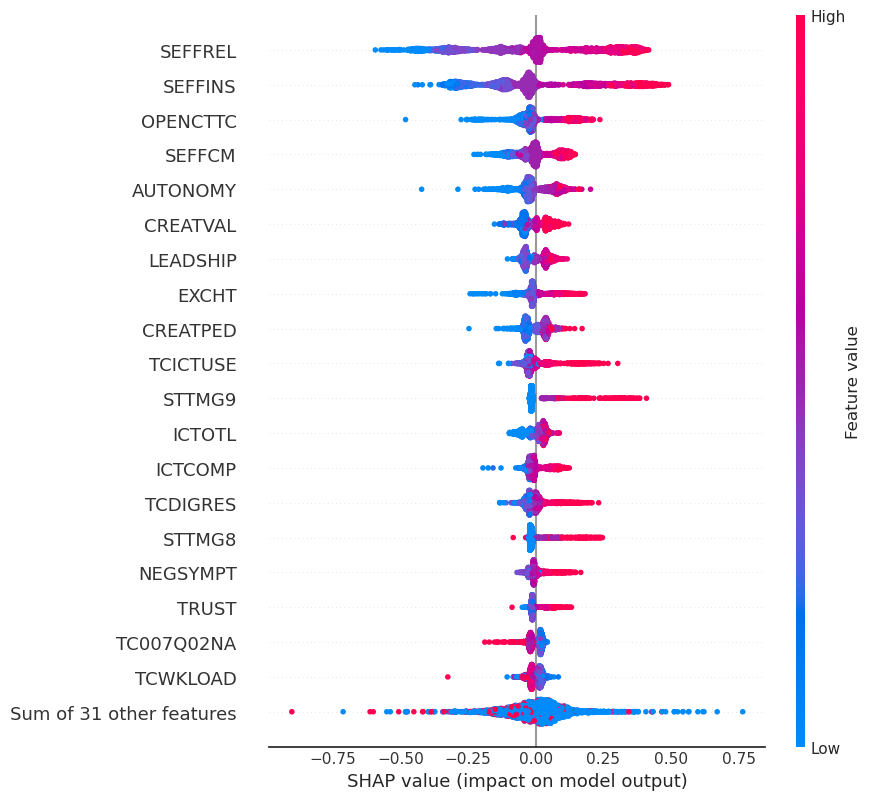

In [45]:
import shap

# SHAP 시각화 초기화
shap.initjs()

# Explainer 생성 (TreeExplainer는 트리 기반 모델에 최적화됨)
explainer = shap.TreeExplainer(final_model_top50)

# SHAP 값 계산
shap_values = explainer(X_top50)

# Beeswarm Plot 그리기
# max_display: 상위 N개의 특성만 시각화
shap.plots.beeswarm(shap_values, max_display=20)

### SHAP Dependence Plots (Scatter)
지정된 변수들(`SEFFINS`, `SEFFREL`, `OPENCTTC`, `SEFFCM`)에 대해 SHAP 의존성 산점도(Dependence Plot)를 그립니다.
이 그래프는 특성 값의 변화에 따른 SHAP 값(영향력)의 변화를 보여주며, 색상은 상호작용이 가장 강한 다른 특성을 나타냅니다.

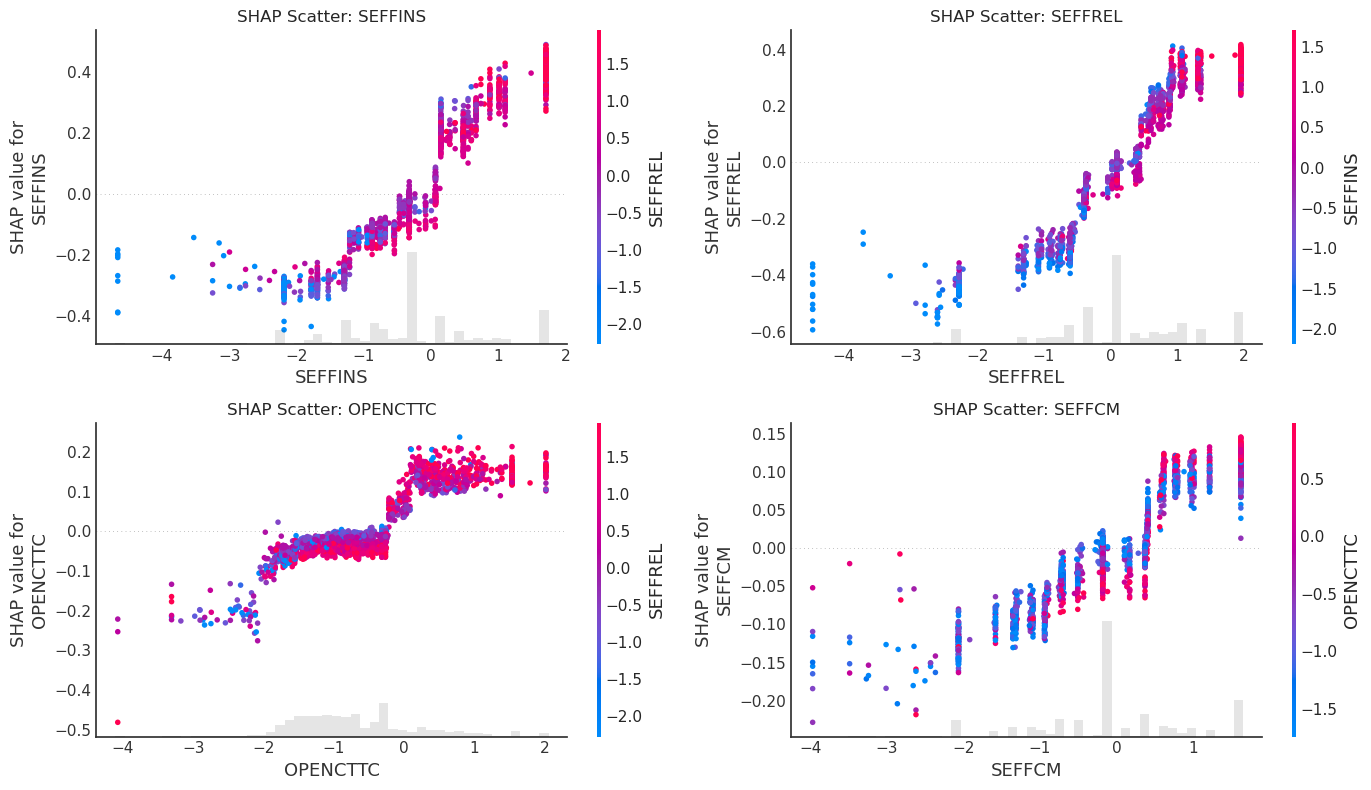

In [54]:
target_features = ['SEFFINS', 'SEFFREL', 'OPENCTTC', 'SEFFCM']

# 2x2 서브플롯 생성
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()  # 1차원 배열로 변환하여 인덱싱 편하게 함

for i, feature in enumerate(target_features):
    # 현재 축(ax) 지정
    ax = axes[i]
    
    # SHAP Scatter Plot 그리기
    # show=False로 설정하여 현재 축에 그림
    shap.plots.scatter(shap_values[:, feature], color=shap_values, show=False, ax=ax)

    ax.set_title(f"SHAP Scatter: {feature}", fontsize=12)

plt.tight_layout()
plt.show()

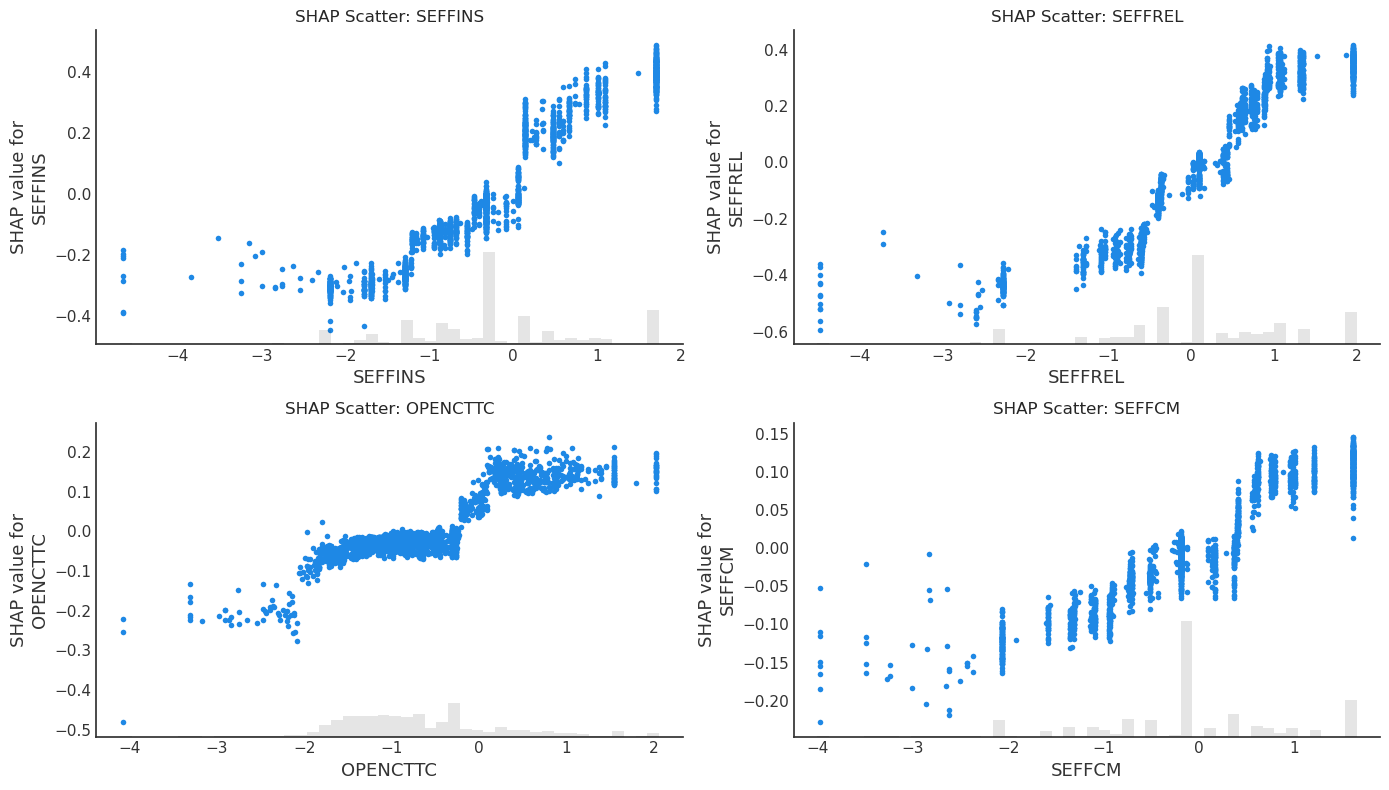

In [ ]:
target_features = ['SEFFINS', 'SEFFREL', 'OPENCTTC', 'SEFFCM']

# 2x2 서브플롯 생성
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
axes = axes.flatten()  # 1차원 배열로 변환하여 인덱싱 편하게 함

for i, feature in enumerate(target_features):
    # 현재 축(ax) 지정
    ax = axes[i]
    
    # SHAP Scatter Plot 그리기
    # show=False로 설정하여 현재 축에 그림
    shap.plots.scatter(shap_values[:, feature], show=False, ax=ax)

    ax.set_title(f"SHAP Scatter: {feature}", fontsize=12)

plt.tight_layout()
plt.show()

In [57]:
X_top20 = X_top50[top50_features[:20]]

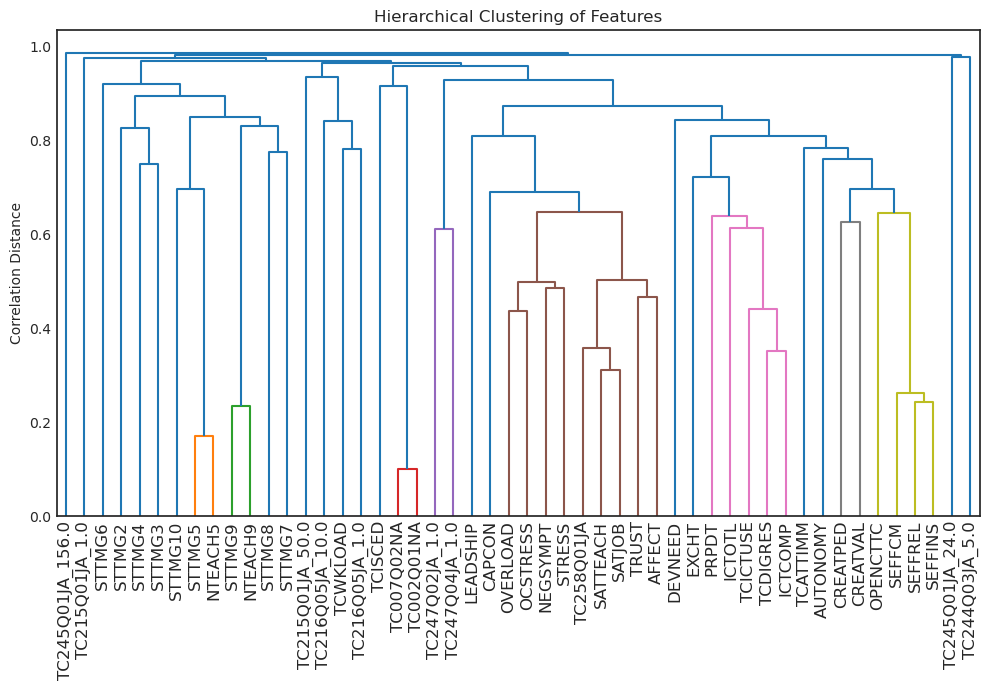

In [62]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Compute absolute correlation distance matrix
abs_corr = X_top50.corr().abs()
distance_matrix = 1- abs_corr
distance_matrix = squareform(distance_matrix)

# Hierarchical clustering
clustering = hierarchy.linkage(distance_matrix, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 7))

hierarchy.dendrogram(clustering, labels=abs_corr.columns)

plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=12)
plt.ylabel('Correlation Distance')
plt.title("Hierarchical Clustering of Features")
plt.tight_layout()
plt.show()

In [63]:
masker = shap.maskers.Partition(X_top50, clustering=clustering)
explainer2 = shap.PartitionExplainer(model_top50.predict, masker)
shap_values2 = explainer2(X_top50)

TypeError: GradientBoostingRegressor.predict() missing 1 required positional argument: 'X'

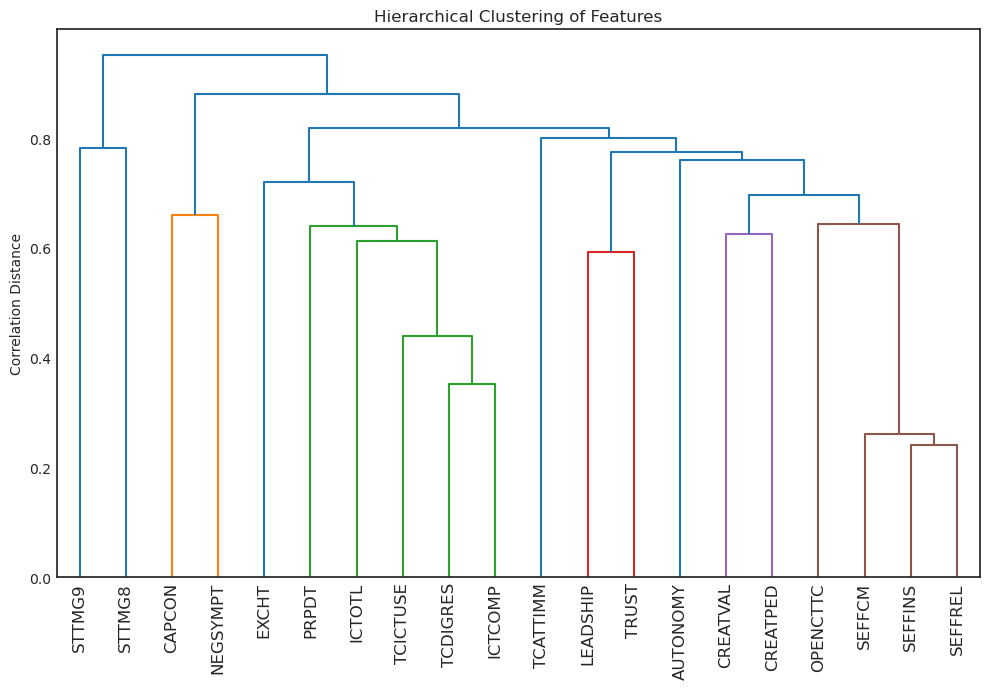

In [ ]:
fig = plt.figure(figsize=(6,12))
ax0 = fig.add_subplot(211)
shap.plots.bar(shap_values, max_display=11, show=False)
ax1 = fig.add_subplot(212)
shap.plots.bar(
shap_values2, max_display=11, show=False, clustering_cutoff=0.6
)
plt.tight_layout()
plt.show()

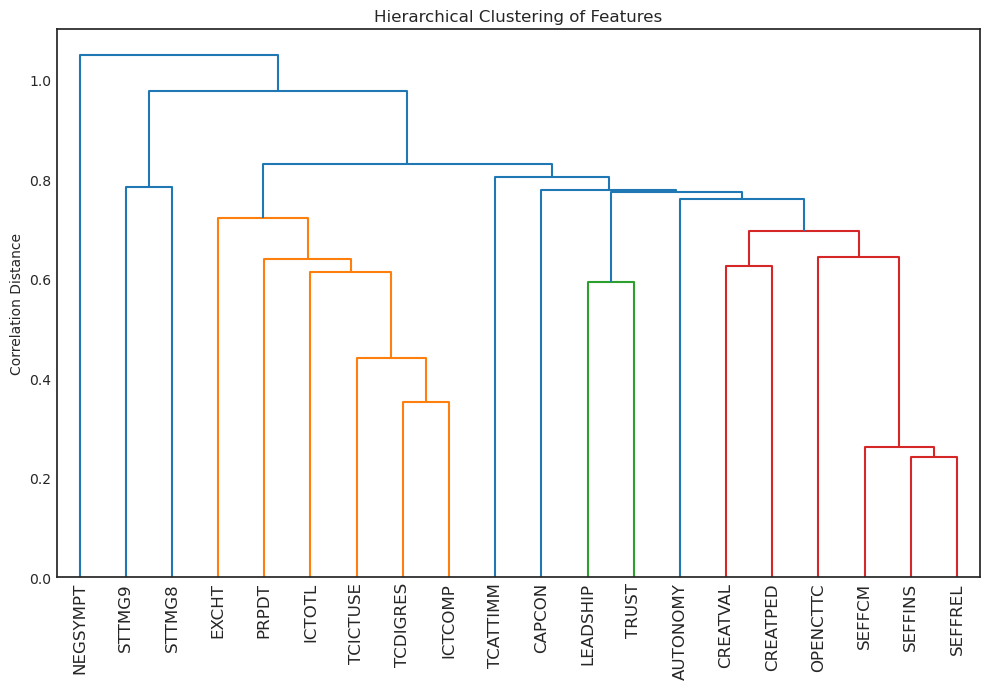

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Compute absolute correlation distance matrix
abs_corr = X_top20.corr()
distance_matrix = 1- abs_corr
distance_matrix = squareform(distance_matrix)

# Hierarchical clustering
clustering = hierarchy.linkage(distance_matrix, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 7))

hierarchy.dendrogram(clustering, labels=abs_corr.columns)

plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=12)
plt.ylabel('Correlation Distance')
plt.title("Hierarchical Clustering of Features")
plt.tight_layout()
plt.show()

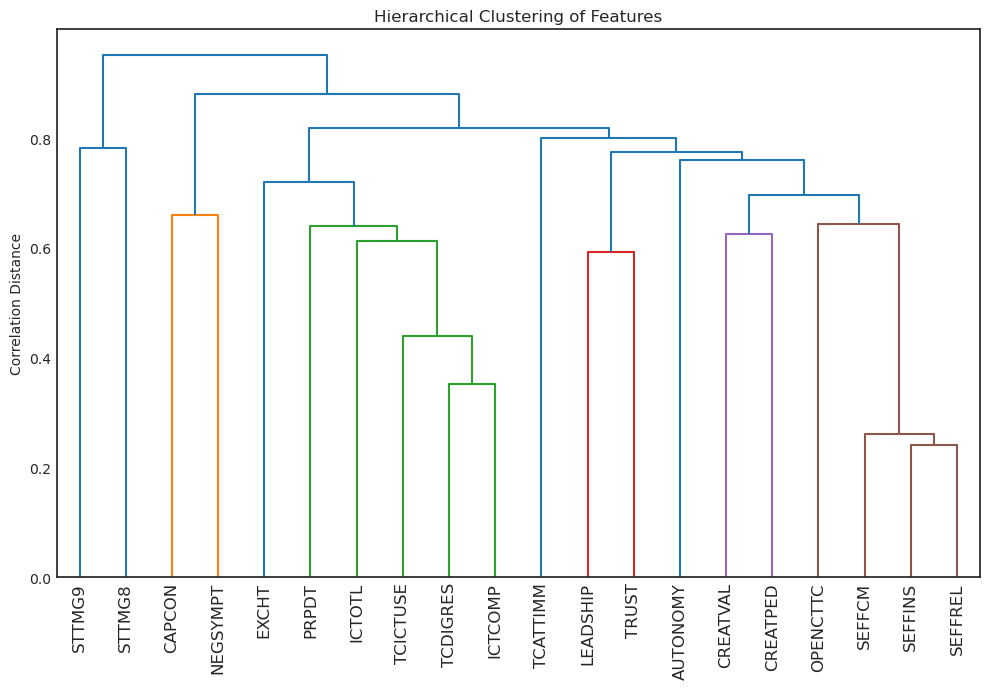

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

# Compute absolute correlation distance matrix
abs_corr = X_top20.corr().abs()
distance_matrix = 1- abs_corr
distance_matrix = squareform(distance_matrix)

# Hierarchical clustering
clustering = hierarchy.linkage(distance_matrix, method='average')

# Plot dendrogram
plt.figure(figsize=(10, 7))

hierarchy.dendrogram(clustering, labels=abs_corr.columns)

plt.xticks(rotation=90)
plt.tick_params(axis='x', labelsize=12)
plt.ylabel('Correlation Distance')
plt.title("Hierarchical Clustering of Features")
plt.tight_layout()
plt.show()